<a href="https://colab.research.google.com/github/Nayoung-young/prj-ecommerce-ltv/blob/main/e_commerce_LTV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# _0.라이브러리 임포트

In [1]:
!pip install plotly
!pip install Lifetimes
!pip install nb_black

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
import pandas as pd # python에서의 엑셀과 같은 역할
import numpy as np # 계산을 편하게 해 주는 라이브러리
import matplotlib as mpl
import matplotlib.pyplot as plt # 시각화
import seaborn as sns # 시각화
import math

import matplotlib.ticker as ticker # 시각화
import matplotlib.dates as mdates # 시각화

import datetime as dt

import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style='white')

# from other 
import matplotlib.colors as mcolors
from sklearn.metrics import (silhouette_score,
                             calinski_harabasz_score,
                             davies_bouldin_score)
%matplotlib inline
sns.set_style('whitegrid')
palette = 'Set2'

# sns.set(font_scale=2)

# _1. 데이터 불러오기 

In [3]:
%%time
df = pd.read_csv('/content/e-commerce_LTV.csv', encoding= 'unicode_escape')
df_base = df.copy()

CPU times: user 826 ms, sys: 167 ms, total: 993 ms
Wall time: 1.01 s


In [4]:
df_base.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
len(df_base['InvoiceNo'].unique().tolist()) # InvoiceNo가 primary key인가? -> Nope 

25900

In [7]:
print(min(df_base['Quantity'].tolist()))
print(max(df_base['Quantity'].tolist())) # Quantity 범위 확인 

-80995
80995


In [8]:
quantity = df_base['Quantity'].tolist() 

print(len(list(filter(lambda x: x < 0, quantity)))) # quantity < 0 인 경우 
print(len(list(filter(lambda x: x > 0, quantity)))) # quantity > 0 인 경우 

10624
531285


In [9]:
sum(df_base['Quantity'].dropna())

5176450

In [10]:
# df_base['Country'].unique().tolist() # Country 고유값

In [11]:
# df_base.groupby(['Country']).agg(country_cnt = ('Country', 'count')).reset_index().sort_values(by = 'country_cnt', ascending =False)

#_1. 데이터 전처리

In [12]:
df_base.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

## 1.1 컬럼명 바꾸기 

In [13]:
# 컬럼 이름 snake case 로 rename 
%%time
df_base.rename(columns = {'InvoiceNo':'invoice_no', 
                        'StockCode':'stock_code', 
                        'Quantity': 'quantity',
                        'Description':'description',
                        'InvoiceDate': 'invoice_date',
                        'UnitPrice': 'unit_price', 
                        'CustomerID': 'customer_id', 
                        'Country':'country'}, inplace = True)

CPU times: user 920 µs, sys: 0 ns, total: 920 µs
Wall time: 930 µs


In [14]:
LTV_columns = ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'customer_id']
df_LTV = df_base[LTV_columns]

In [15]:
df_LTV.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   invoice_no    541909 non-null  object 
 1   stock_code    541909 non-null  object 
 2   quantity      541909 non-null  int64  
 3   invoice_date  541909 non-null  object 
 4   unit_price    541909 non-null  float64
 5   customer_id   406829 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 24.8+ MB


## 1.2 결측값 처리 
- customer_id: 
  - 결측값 = 비회원으로 추정
  - 추후 LTV 계산에서 활용하지는 않을 것이지만 fillna(0)
  - object로 타입 변환 

In [416]:
df_LTV_01 = df_LTV.copy()

In [417]:
## customer_id type 변환해도될지 체크 
%%time 
list(filter(lambda x: str(x)[-1] != '0', df_LTV_01['customer_id'].unique().tolist()))

CPU times: user 11.8 ms, sys: 0 ns, total: 11.8 ms
Wall time: 14.3 ms


[nan]

In [418]:
df_LTV_01['customer_id'].isna().sum() # customer_id 결측값 확인 

135080

In [419]:
df_LTV_01.sample(5)

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id
171072,551352,22824,2,4/28/2011 10:20,35.95,16637.0
343385,566950,84029G,8,9/15/2011 16:34,4.25,17594.0
446481,574898,21328,8,11/7/2011 15:07,1.65,16242.0
127984,547249,21914,1,3/22/2011 9:27,2.46,NaN
322768,565234,22684,2,9/2/2011 9:38,2.46,NaN


In [420]:
df_LTV_01[df_LTV_01['invoice_no'] == '536865' ] # 비회원으로 추정, LTV 계산에서 활용 불가 

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id
5546,536865,10002,5,12/3/2010 11:28,1.66,NaN
5547,536865,15056bl,2,12/3/2010 11:28,12.72,NaN
5548,536865,18098c,7,12/3/2010 11:28,5.06,NaN
5549,536865,20615,1,12/3/2010 11:28,4.21,NaN
5550,536865,20655,1,12/3/2010 11:28,2.51,NaN
...,...,...,...,...,...,...
5681,536865,85099B,1,12/3/2010 11:28,4.21,NaN
5682,536865,85152,1,12/3/2010 11:28,4.21,NaN
5683,536865,85176,1,12/3/2010 11:28,1.66,NaN
5684,536865,M,1,12/3/2010 11:28,2.55,NaN


In [421]:
df_LTV_01['customer_id'] = df_LTV_01['customer_id'].fillna(0)

In [422]:
df_LTV_01['customer_id'].isna().sum() # customer_id

0

In [423]:
%%time 
df_LTV_01 = df_LTV_01.astype({'customer_id' : 'int'}) # float 였으므로 .0 없애기 위해 먼저 int로 변환 
df_LTV_01 = df_LTV_01.astype({'customer_id' : 'str'})

CPU times: user 231 ms, sys: 68.6 ms, total: 299 ms
Wall time: 303 ms


In [424]:
## invoice_no, stock_code도 type str로 변경 
df_LTV_01 = df_LTV_01.astype({'invoice_no' : 'str'})
df_LTV_01 = df_LTV_01.astype({'stock_code' : 'str'})

In [425]:
df_LTV_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   invoice_no    541909 non-null  object 
 1   stock_code    541909 non-null  object 
 2   quantity      541909 non-null  int64  
 3   invoice_date  541909 non-null  object 
 4   unit_price    541909 non-null  float64
 5   customer_id   541909 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 24.8+ MB


## 1.3 invoice_date
- 현재 type: object -> datetime으로 변경 

In [426]:
df_LTV_01.sample(10)

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id
246518,558704,22112,3,7/1/2011 12:50,4.95,17505
489725,578024,22467,12,11/22/2011 13:27,2.55,12705
454223,575516,84031B,6,11/10/2011 10:45,4.65,17340
538650,581412,22576,20,12/8/2011 14:38,0.85,14415
398519,571243,22621,12,10/14/2011 15:26,1.65,14595
254312,559307,21934,5,7/7/2011 13:02,1.65,15356
331587,566019,84378,12,9/8/2011 12:44,1.45,17243
133514,547788,21980,1,3/25/2011 12:00,0.83,0
238123,557898,21711,4,6/23/2011 14:35,4.95,17314
282454,561650,22738,10,7/28/2011 15:31,1.65,15329


In [427]:
df_LTV_01['invoice_datetime'] = pd.to_datetime(df_LTV_01['invoice_date'], format = '%m/%d/%Y %H:%M')

df_LTV_01['invoice_date'] = df_LTV_01['invoice_datetime'].dt.date
df_LTV_01['invoice_date'] = pd.to_datetime(df_LTV_01['invoice_date'], format = '%Y-%m-%d')


In [428]:
df_LTV_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   invoice_no        541909 non-null  object        
 1   stock_code        541909 non-null  object        
 2   quantity          541909 non-null  int64         
 3   invoice_date      541909 non-null  datetime64[ns]
 4   unit_price        541909 non-null  float64       
 5   customer_id       541909 non-null  object        
 6   invoice_datetime  541909 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(3)
memory usage: 28.9+ MB


In [429]:
# date관련 데이터 추가하기: 월 정보
# df_LTV_01['invoice_year'] = df_LTV_01['invoice_datetime'].dt.year
# df_LTV_01['invoice_month'] = df_LTV_01['invoice_datetime'].dt.month
# df_LTV_01['invoice_day'] = df_LTV_01['invoice_datetime'].dt.day

# df_LTV_01 = df_LTV_01.astype({'invoice_year' : 'int'}) 
# df_LTV_01 = df_LTV_01.astype({'invoice_month' : 'int'}) 
# df_LTV_01 = df_LTV_01.astype({'invoice_day' : 'int'}) 

## 최종 모델에서 활용하지 않았음 

df_LTV_01.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,invoice_datetime
0,536365,85123A,6,2010-12-01,2.55,17850,2010-12-01 08:26:00
1,536365,71053,6,2010-12-01,3.39,17850,2010-12-01 08:26:00
2,536365,84406B,8,2010-12-01,2.75,17850,2010-12-01 08:26:00
3,536365,84029G,6,2010-12-01,3.39,17850,2010-12-01 08:26:00
4,536365,84029E,6,2010-12-01,3.39,17850,2010-12-01 08:26:00


#_2. 파악을 위한 시각화 

**[ 변수 정보 ]**
*   InvoiceNo: Invoice number that consists 6 digits. If this code starts with letter 'c', it indicates a cancellation.
*   StockCode: Product code that consists 5 digits.
*   Description: Product name.
*   Quantity: The quantities of each product per transaction.
*   InvoiceDate: Represents the day and time when each transaction was generated.
*   CustomerID: Customer number that consists 5 digits. Each customer has a unique customer ID.
*   Country: Name of the country where each customer resides.


In [430]:
# 시각화 라이브러리 
import plotly.graph_objs as go
from plotly.offline import iplot

In [431]:
world_map = df_base[['customer_id', 'invoice_no', 'country']
              ].groupby(['customer_id', 'invoice_no', 'country']
                       ).count().reset_index()

countries = world_map['country'].value_counts()

data = dict(type='choropleth',
            locations = countries.index,
            locationmode = 'country names',
            z = countries,
            text = countries.index,
            colorbar = {'title':'Orders'},
            colorscale='Viridis',
            reversescale = False)

layout = dict(title={'text': "Number of Orders by Countries",
                     'y':0.9,
                     'x':0.5,
                     'xanchor': 'center',
                     'yanchor': 'top'},
              geo = dict(resolution = 50,
                         showocean = True,
                         oceancolor = "LightBlue",
                         showland = True,
                         landcolor = "whitesmoke",
                         showframe = True),
             template = 'plotly_white',
             height = 600,
             width = 1000)

choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate = False)

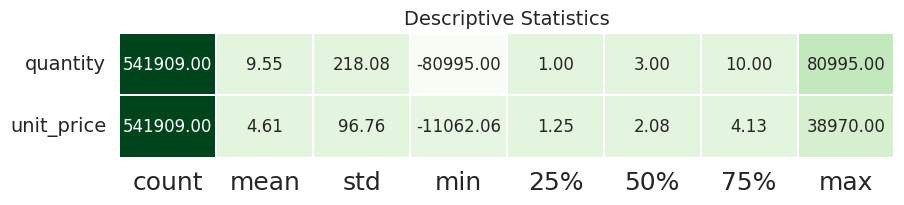

In [432]:
def desc_stats(dataframe):
    desc_df = pd.DataFrame(index= dataframe.columns, 
                           columns= dataframe.describe().T.columns,
                           data= dataframe.describe().T)
    
    f,ax = plt.subplots(figsize=(10,
                                 desc_df.shape[0] * 0.81))
    sns.heatmap(desc_df,
                annot = True,
                cmap = "Greens",
                fmt = '.2f',
                ax = ax,
                linecolor = 'white',
                linewidths = 1.1,
                cbar = False,
                annot_kws = {"size": 12})
    plt.xticks(size = 18)
    plt.yticks(size = 14,
               rotation = 0)
    plt.title("Descriptive Statistics", size = 14)
    plt.show()
    
desc_stats(df_LTV_01.select_dtypes(include = [float, int]))

* 취소된 주문내역 때문에 quantity < 0인 row 존재 
* total_price = quantity * unit_price로 구할 예정 

## 2.1 unit_price, quantity에 대한 확인 
- quantity < 0 인 부분 확인  
- stock_code가 같은데도 unit_price가 다른 경우에 대한 확인 

In [433]:
df_LTV_01[df_LTV_01['quantity'] < 0].sample(5)

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,invoice_datetime
190938,C553222,23201,-1,2011-05-16,2.08,13662,2011-05-16 10:10:00
360539,C568232,20719,-6,2011-09-26,0.85,14808,2011-09-26 11:27:00
432240,C573864,23168,-2,2011-11-01,1.04,15311,2011-11-01 11:55:00
249638,C558905,72760B,-1,2011-07-04,9.95,13826,2011-07-04 16:27:00
340224,C566614,D,-1,2011-09-13,102.24,16029,2011-09-13 17:28:00


In [434]:
# pd.set_option('display.max_columns', None) ## 모든 열을 출력한다.
# pd.set_option('display.max_rows', None) ## 모든 열을 출력한다.

In [435]:
# df_LTV_01[df_LTV_01['customer_id'] == 12471] # quantity < 0인 행이 있는 customer 확인 

- invoice_no 가장 앞에 C가 있으면 취소한 내역, 취소했을 시 quantity < 0 
- but, C 뒤 번호로 어떤 내역을 취소한 건지 확인 불가 (해당하는 invoice_no 없음) -> 주문 전체 취소라면 그 주문번호 앞에 C가 붙어있지만, 아니라면 아예 새로운 주문번호 + C 를 부여하는 듯? 

구매 내역만 필요하긴 하지만, 
- 구매 건수: 환불 건수 제외하고 nunique 
- 총 주문금액: 주문 금액 - 환불금액 의 sum이어야 함 

quantity < 0 인 경우를 확인해보자. 

In [436]:
df_LTV_01[df_LTV_01['unit_price'] == 0].sample(5) # unit_price == 0인 경우 확인 

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,invoice_datetime
173242,551664,20933,-3,2011-05-03,0.0,0,2011-05-03 12:34:00
280821,561504,21361,-7,2011-07-27,0.0,0,2011-07-27 14:15:00
313668,564530,21452,1,2011-08-25,0.0,0,2011-08-25 14:57:00
433687,573978,21644,27,2011-11-02,0.0,0,2011-11-02 11:02:00
115806,546138,21815,-300,2011-03-09,0.0,0,2011-03-09 16:34:00


In [437]:
df_LTV_01[df_LTV_01['unit_price'] < 0].head() # unit_price < 0인 경우 확인 

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,invoice_datetime
299983,A563186,B,1,2011-08-12,-11062.06,0,2011-08-12 14:51:00
299984,A563187,B,1,2011-08-12,-11062.06,0,2011-08-12 14:52:00


In [438]:
df_base[df_base['stock_code'] == 'B'] # unit_price < 0 인 상품 확인 

# stock_code = 'B'인 상품: 	Adjust bad debt	 <- 즉, 구매 내역은 아님 
# 어차피 customer_id = NaN이기 때문에 추후 드랍할 예정 

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
299982,A563185,B,Adjust bad debt,1,8/12/2011 14:50,11062.06,NaN,United Kingdom
299983,A563186,B,Adjust bad debt,1,8/12/2011 14:51,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,8/12/2011 14:52,-11062.06,NaN,United Kingdom


In [439]:
print((df_LTV_01[df_LTV_01['unit_price'] == 0].shape)) 
print((df_LTV_01[df_LTV_01['customer_id'] == 0].shape))

print((df_LTV_01[(df_LTV_01['customer_id'] == 0) & (df_LTV_01['unit_price'] == 0)].shape))

(2515, 7)
(0, 7)
(0, 7)


In [440]:
# df_LTV_01[ (df_LTV_01['unit_price'] == 0) & (df_LTV_01['customer_id'] != 0) ]

In [441]:
df_base[df_base['stock_code'] == '22034'] # unit_price == 0 인 상품 확인 

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
8828,537153,22034,ROBIN CHRISTMAS CARD,3,12/5/2010 13:03,0.42,16718.0,United Kingdom
19996,537999,22034,NaN,-223,12/9/2010 11:44,0.00,NaN,United Kingdom
35347,539436,22034,ROBIN CHRISTMAS CARD,5,12/17/2010 14:49,0.42,NaN,United Kingdom
44297,C540164,22034,ROBIN CHRISTMAS CARD,-12,1/5/2011 12:02,0.42,14911.0,EIRE
243332,558445,22034,NaN,-18,6/29/2011 13:39,0.00,NaN,United Kingdom
270602,560578,22034,NaN,12,7/19/2011 15:12,0.00,NaN,United Kingdom
469110,576580,22034,NaN,-5,11/15/2011 14:15,0.00,NaN,United Kingdom
490649,578065,22034,ROBIN CHRISTMAS CARD,1,11/22/2011 15:41,0.83,NaN,United Kingdom
501878,578833,22034,ROBIN CHRISTMAS CARD,1,11/25/2011 15:23,0.83,NaN,United Kingdom


- unit_price = 0인 이유에 대해 확정짓기 어려움 

    - 같은 stock_code인데도 unit_price = 0 인 경우 존재 
    -  unit_price = 0 인 경우 중 customer_id이 NaN이었던 경우가 대부분이긴 했으나, 이유를 추측하기 어려움 


**추측**
1.   단기성 이벤트로 해당 상품을 무료로 증정한 적이 있었다 
2.   프로모션이 진행됨에 따라 같은 stock_code여도 unit_price가 다를 수 있다 

## 2.2 unit_price, quantity에 대한 추가 전처리 


In [442]:
# df_LTV_01['total_price'] = df_LTV_01['quantity'] * df_LTV_01['unit_price']

In [443]:
# df_LTV_01.groupby('customer_id').agg({"total_price": "sum"})

In [444]:
## rollback을 위해 copy 
df_LTV_02 = df_LTV_01.copy()
# df_LTV_02 = df_LTV_02[df_LTV_02['quantity'] > 0]

In [445]:
# ## total_price = quantity * unit_price 열 추가 
df_LTV_02['total_price'] = df_LTV_02['quantity'] * df_LTV_02['unit_price']

In [446]:
# ## total_price = quantity * unit_price 열 추가 
# df_LTV_02['total_price'] = df_LTV_02['quantity'] * df_LTV_02['unit_price']

In [447]:
df_LTV_01.shape

(541909, 7)

In [448]:
df_LTV_02.shape

(541909, 8)

In [449]:
## customer_id == '0'인 경우 drop 
df_LTV_02 = df_LTV_02[ df_LTV_02['customer_id'] != '0']

Hypothetically, we could consider to use the invoice numbers as dummy variables that each represent an otherwise unknown customer. But this would distort our model. We are interested in repeat customers and their demand patterns. 

(출처: https://towardsdatascience.com/buy-til-you-die-predict-customer-lifetime-value-in-python-9701bfd4ddc0) 

In [450]:
df_LTV_02.shape

(406829, 8)

In [451]:
df_LTV_02.info() # 최종 LTV 계산에 활용할 데이터 형태 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   invoice_no        406829 non-null  object        
 1   stock_code        406829 non-null  object        
 2   quantity          406829 non-null  int64         
 3   invoice_date      406829 non-null  datetime64[ns]
 4   unit_price        406829 non-null  float64       
 5   customer_id       406829 non-null  object        
 6   invoice_datetime  406829 non-null  datetime64[ns]
 7   total_price       406829 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 27.9+ MB


In [452]:
df_LTV_02.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,invoice_datetime,total_price
0,536365,85123A,6,2010-12-01,2.55,17850,2010-12-01 08:26:00,15.30
1,536365,71053,6,2010-12-01,3.39,17850,2010-12-01 08:26:00,20.34
2,536365,84406B,8,2010-12-01,2.75,17850,2010-12-01 08:26:00,22.00
3,536365,84029G,6,2010-12-01,3.39,17850,2010-12-01 08:26:00,20.34
4,536365,84029E,6,2010-12-01,3.39,17850,2010-12-01 08:26:00,20.34


#_3. Life Time Value (고객 생애가치) 계산 

In [481]:
max(df_LTV_01['invoice_date'])

Timestamp('2011-12-09 00:00:00')

In [482]:
today_date = dt.datetime(2011, 12, 9)

## 3.1 RFM metrics 

**RFM Metrics**
- recency:
    - the number of days between her first and her latest transaction 
    - affects retention, a measure of engagement
- frequency:  the number of time periods in which one or more repeat purchases were recorded
- monetary: affects a customer's lifetime value 
- T: the number of days between her “birth” — the first invoice

RFM scoring을 통해 고객을 segmentation할 수도 있음 

In [483]:
df_LTV_02[df_LTV_02['customer_id'] == '14527']

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,invoice_datetime,total_price
141,C536379,D,-1,2010-12-01,27.50,14527,2010-12-01 09:41:00,-27.50
8963,537159,22112,6,2010-12-05,4.95,14527,2010-12-05 13:17:00,29.70
8964,537159,22111,1,2010-12-05,4.95,14527,2010-12-05 13:17:00,4.95
8965,537159,21479,1,2010-12-05,3.75,14527,2010-12-05 13:17:00,3.75
8966,537159,22114,6,2010-12-05,3.95,14527,2010-12-05 13:17:00,23.70
...,...,...,...,...,...,...,...,...
533807,581114,22111,1,2011-12-07,4.95,14527,2011-12-07 12:19:00,4.95
533808,581114,22835,2,2011-12-07,4.95,14527,2011-12-07 12:19:00,9.90
533809,581114,22114,6,2011-12-07,4.25,14527,2011-12-07 12:19:00,25.50
533810,581114,21479,2,2011-12-07,4.25,14527,2011-12-07 12:19:00,8.50


In [484]:
# df_LTV_02[df_LTV_02['customer_id'] == '12348']

In [485]:
%%time 
ltv_df = df_LTV_02.groupby("customer_id").agg(
    {
        "invoice_date": [
            lambda x: (x.max() - x.min()).days,
            lambda x: (today_date - x.min()).days,
        ],
        "total_price": "sum",
    }
)

# invoice_df = df_LTV_02[ df_LTV_02['quantity'] > 0 ].groupby("customer_id").agg( { "invoice_no": "nunique" })
invoice_df = df_LTV_02[ df_LTV_02['quantity'] > 0 ].groupby("customer_id").agg( { "invoice_date": "nunique" })


ltv_df.columns = ltv_df.columns.droplevel(0)

invoice_df.head()

ltv_df = pd.merge(ltv_df, invoice_df, left_index=True, right_index=True)
ltv_df.columns = ["recency", "T", "monetary", "frequency"]

ltv_df.head()

CPU times: user 1.5 s, sys: 3.25 ms, total: 1.5 s
Wall time: 1.52 s


,recency,T,monetary,frequency
customer_id,,,,
12346,0,325,0.00,1
12347,365,367,4310.00,7
12348,283,358,1797.24,4
12349,0,18,1757.55,1
12350,0,310,334.40,1


In [486]:
ltv_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4339 entries, 12346 to 18287
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   recency    4339 non-null   int64  
 1   T          4339 non-null   int64  
 2   monetary   4339 non-null   float64
 3   frequency  4339 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 169.5+ KB


In [487]:
%%time 
# Regency & Tenure (unit: week)
# ltv_df["recency"] = ltv_df["recency"] / 7
# ltv_df["T"] = ltv_df["T"] / 7

# Frequency (drop if frequency == 0)
# it just counts the days that have seen a transaction since the second invoice
ltv_df['frequency'] = ltv_df['frequency'] - 1 
ltv_df = ltv_df[ltv_df["frequency"] > 1]

# Average Order Value  
ltv_df["monetary"] = ltv_df["monetary"] / ltv_df["frequency"]


CPU times: user 3.82 ms, sys: 0 ns, total: 3.82 ms
Wall time: 5.87 ms


In [488]:
ltv_df[ ltv_df.index == '15311']

,recency,T,monetary,frequency
customer_id,,,,
15311,373,373,667.633034,89


In [489]:
ltv_df.head()

# recency = 가장 최근 구매와 첫 구매와의 차이 (일)
# T = 첫 구매 이후 시간 (일) (T <= recency)
# frequency = 구매가 발생한 일수 (일)
# monetary = 구매 일수 별 평균 구매금액 (원)

,recency,T,monetary,frequency
customer_id,,,,
12347,365,367,718.333333,6
12348,283,358,599.080000,3
12352,260,296,257.568333,6
12356,303,325,1405.715000,2
12359,324,331,2081.843333,3


In [490]:
ltv_df[ ltv_df['recency'] > ltv_df['T'] ]

,recency,T,monetary,frequency
customer_id,,,,


In [491]:
df_LTV_02 [ df_LTV_02['customer_id'] == '15311']

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,invoice_datetime,total_price
106,536381,22139,23,2010-12-01,4.25,15311,2010-12-01 09:41:00,97.75
107,536381,84854,5,2010-12-01,4.95,15311,2010-12-01 09:41:00,24.75
108,536381,22411,10,2010-12-01,1.95,15311,2010-12-01 09:41:00,19.50
109,536381,82567,2,2010-12-01,2.10,15311,2010-12-01 09:41:00,4.20
110,536381,21672,6,2010-12-01,1.25,15311,2010-12-01 09:41:00,7.50
...,...,...,...,...,...,...,...,...
541746,581571,23167,96,2011-12-09,0.69,15311,2011-12-09 12:00:00,66.24
541747,581571,21314,48,2011-12-09,1.85,15311,2011-12-09 12:00:00,88.80
541748,581571,21137,24,2011-12-09,3.39,15311,2011-12-09 12:00:00,81.36
541749,581571,44234,1,2011-12-09,0.21,15311,2011-12-09 12:00:00,0.21


In [505]:
ltv_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1916 entries, 12347 to 18287
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   recency    1916 non-null   int64  
 1   T          1916 non-null   int64  
 2   monetary   1916 non-null   float64
 3   frequency  1916 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 74.8+ KB


## 3.2 Split of Training and Test Dataset 
- 방법1) calibration_and_holdout_data 사용 
  - 장점: 편리, 원하는대로 시각화 쉽게 가능 
  - 단점: 내가 생각한대로 custom하여 metrics계산하기 어려움 
- 방법2) 직접 240일까지 잘라서 ltv_df_train과 ltv_df_test로 분리 
  - 장점: 내가 생각한대로 나눌 수 있음 
  - 단점: 성능 보장 X, 더 번거로움 
<- 그래도 방법2로 좀 더 해보고,안되면 방법1로 다시 하자 

In [502]:
from datetime import timedelta

In [492]:
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import \
    calibration_and_holdout_data, \
    summary_data_from_transaction_data, \
    calculate_alive_path
from lifetimes.plotting import \
    plot_frequency_recency_matrix, \
    plot_probability_alive_matrix, \
    plot_period_transactions, \
    plot_history_alive, \
    plot_cumulative_transactions, \
    plot_calibration_purchases_vs_holdout_purchases, \
    plot_transaction_rate_heterogeneity, \
    plot_dropout_rate_heterogeneity

In [503]:
%%time 
# train/test split (calibration/holdout)
t_holdout = 240                                         # days to reserve for holdout period

max_date = df_LTV_02["invoice_date"].max()                     # end date of observations
print("end of observations:", max_date)

max_cal_date = max_date - timedelta(days=t_holdout)     # end date of chosen calibration period
print("end of calibration period:", max_cal_date)

df_ch = calibration_and_holdout_data(
        transactions = df_LTV_02, 
        customer_id_col = "customer_id", 
        datetime_col = "invoice_date", # 그런데 이렇게 되면 환불건수까지 count됨 
        monetary_value_col = "total_price", 
        calibration_period_end = max_cal_date, 
        observation_period_end = max_date, 
        freq = "D")  # Default 'D' for days, 'W' for weeks, 'h' for hours

print("customer behavior in calibration and holdout periods")
pd.options.display.float_format = '{:,.0f}'.format
df_ch

end of observations: 2011-12-09 00:00:00
end of calibration period: 2011-04-13 00:00:00
customer behavior in calibration and holdout periods


,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
customer_id,,,,,,,
12346,0,0,85,0,0,0,240
12347,2,121,127,556,4,25,240
12348,2,110,118,297,1,103,240
12350,0,0,70,0,0,0,240
12352,3,34,56,102,3,20,240
...,...,...,...,...,...,...,...
18272,0,0,6,0,6,18,240
18273,0,0,17,0,2,76,240
18277,0,0,78,0,1,14,240


In [ ]:
# 그런데 이렇게 나누면 위에서 계산한 ltv_df는 활용하지 않는 거잖아 
# 뭐지 

In [504]:
df_ch.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2355 entries, 12346 to 18283
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   frequency_cal           2355 non-null   float64
 1   recency_cal             2355 non-null   float64
 2   T_cal                   2355 non-null   float64
 3   monetary_value_cal      2355 non-null   float64
 4   frequency_holdout       2355 non-null   float64
 5   monetary_value_holdout  2355 non-null   float64
 6   duration_holdout        2355 non-null   float64
dtypes: float64(7)
memory usage: 211.7+ KB


In [506]:
# training: frequency
pd.options.display.float_format = '{:,.3f}'.format

x = df_ch["frequency_cal"].value_counts(normalize=True)
x = x.nlargest(15)
print("frequency:")
x.sort_index(ascending=True)

frequency:


0.000    0.516
1.000    0.210
2.000    0.099
3.000    0.069
4.000    0.027
          ... 
10.000   0.003
11.000   0.003
12.000   0.002
13.000   0.002
14.000   0.002
Name: frequency_cal, Length: 15, dtype: float64

Text(0.5, 1.0, 'customer age T (days): distribution of the customers')

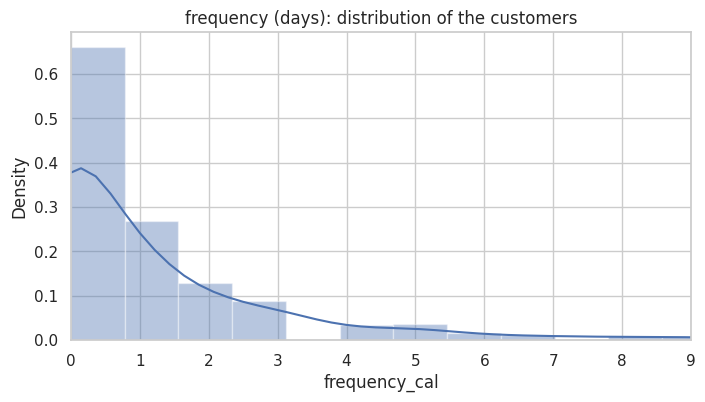

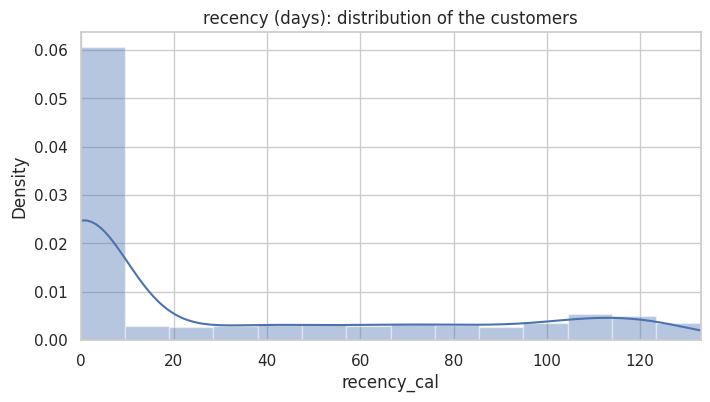

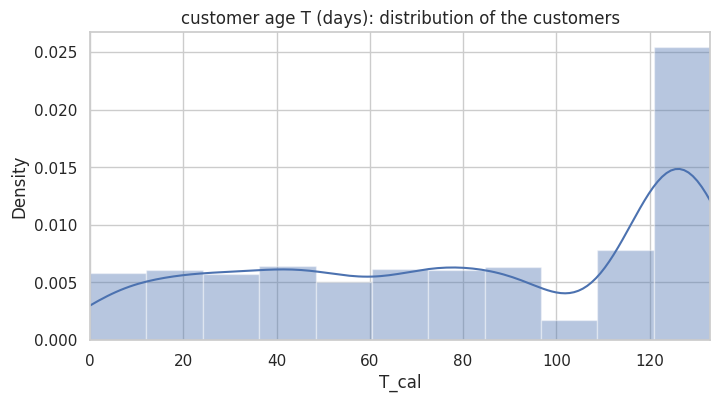

In [507]:
# training: axis length
max_freq = df_ch["frequency_cal"].quantile(0.98)
max_rec = df_ch["recency_cal"].max()
max_T = df_ch["T_cal"].max()


# training
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_ch["frequency_cal"])
ax.set_xlim(0, max_freq)
ax.set_title("frequency (days): distribution of the customers");


# training
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_ch["recency_cal"])
ax.set_xlim(0, max_rec)
ax.set_title("recency (days): distribution of the customers")


# training
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_ch["T_cal"])
ax.set_xlim(0, max_T)
ax.set_title("customer age T (days): distribution of the customers")

## 3.2 BG/NBD 
- BG(Beta Geometric)/NBD(Negative Binomial Distribution)
-  assume that the number of transactions made by each customer follows a Poisson process with a heterogeneity in transaction rates across customers following a gamma distribution

by using `BetaGeoFitter` and `lifetimes` packages.


- LTV 계산 시 outlier를 사전에 제거했어야 하나? 
- 이 글 다시 보기: https://www.analyticsvidhya.com/blog/2020/10/a-definitive-guide-for-predicting-customer-lifetime-value-clv/ 
  - 아무래도 환불한 그 금액을 합산에 고려했어야 

In [493]:
BGF = BetaGeoFitter(penalizer_coef=0.001)  # avoid overfitting
## In typical applications, penalizers on the order of 0.001 to 0.1 are effective

BGF.fit(ltv_df["frequency"], ltv_df["recency"], ltv_df["T"])

<lifetimes.BetaGeoFitter: fitted with 1916 subjects, a: 0.00, alpha: 109.53, b: 0.00, r: 2.33>

In [494]:
BGF.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,2.333148e+00,9.368001e-02,2.149535e+00,2.516761e+00
alpha,1.095271e+02,4.863667e+00,9.999430e+01,1.190599e+02
a,1.755355e-17,2.348308e-11,-4.602683e-11,4.602686e-11
b,3.050054e-07,4.080339e-01,-7.997462e-01,7.997468e-01


## 3.3 Visualization 


In [495]:
# from lifetimes.plotting import plot_frequency_recency_matrix
# from lifetimes.plotting import plot_probability_alive_matrix

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

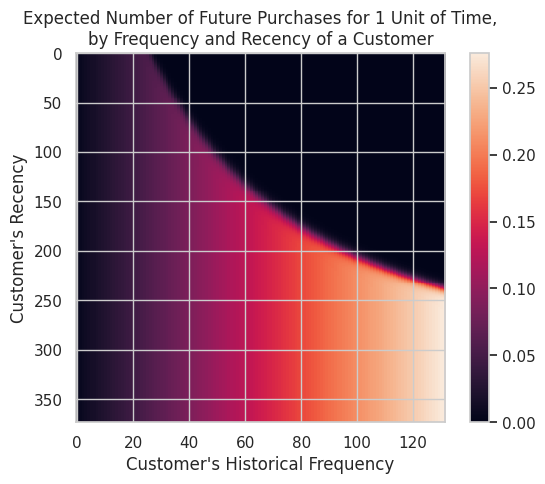

In [496]:
plot_frequency_recency_matrix(BGF)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

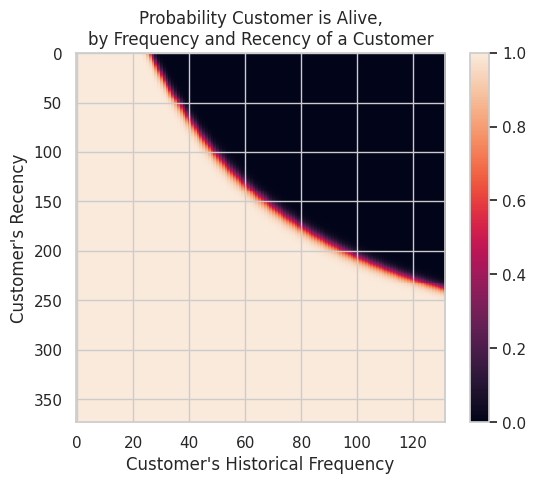

In [497]:
plot_probability_alive_matrix(BGF)

## Expectation 
- Top 10 Expected Number of Transaction (1 Week) 
- Top 10 Expected Number of Transaction (1 Month) 

In [498]:
## - Top 10 Expected Number of Transaction (1 Week)  
BGF.conditional_expected_number_of_purchases_up_to_time(
    1, ltv_df["frequency"], ltv_df["recency"], ltv_df["T"]
).sort_values(ascending=False).head(10).to_frame(
    "Expected Number of Transactions"
).reset_index()

,customer_id,Expected Number of Transactions
0,14911,0.276323
1,12748,0.239019
2,17841,0.234874
3,15311,0.189281
4,14606,0.187208
5,12971,0.150216
6,13089,0.140709
7,14527,0.114674
8,13798,0.112835
9,16422,0.103094


In [499]:
## Top 10 Expected Number of Transaction (1 Month)
BGF.conditional_expected_number_of_purchases_up_to_time(
    4, ltv_df["frequency"], ltv_df["recency"], ltv_df["T"]
).sort_values(ascending=False).head(10).to_frame(
    "Expected Number of Transactions"
).reset_index()

,customer_id,Expected Number of Transactions
0,14911,1.105290
1,12748,0.956076
2,17841,0.939497
3,15311,0.757123
4,14606,0.748834
5,12971,0.600865
6,13089,0.562837
7,14527,0.458695
8,13798,0.451340
9,16422,0.412375


- bg-nbd 모델에서 출력해볼 수 있는 값들 살펴보기 
- 그래프 그려볼 수 있는 것 그려보기 

-- https://lifetimes.readthedocs.io/en/latest/Quickstart.html 살펴보기 (lifetimes 문서) 

In [500]:
# from lifetimes.plotting import plot_period_transactions

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

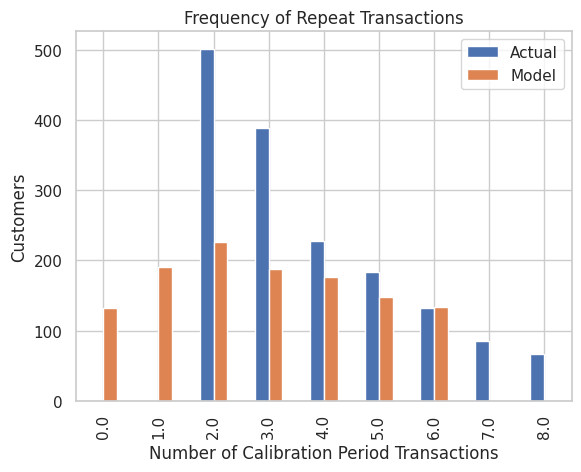

In [501]:
# Model Fitting 
plot_period_transactions(BGF)